# Systems


Numerous dynamic systems are implemented in Underworld. They may be found within the `systems` submodule. For specific information on the different system classes, the user is directed to the API reference available at the Underworld documentation site:

http://underworld2.readthedocs.io/

We will consider here the basic workflow for creating and configuring an Underworld numerical system. The general process is as follows:

1. Create your mesh.
1. Create any required field(s) on the mesh (such as a temperature field).
1. Create any required boundary condition objects. 
1. Create function objects to define any required physical quantities. 
1. Create system. 
1. Create solver and solve system. 

Note that for systems that are solved many times (for perhaps time-stepping), you will generally only create the system (and solver) once, and then solve it numerous times. 

## Boundary Conditions

Boundary conditions form part of your known information for the system you are creating. In Underworld, these *knowns* are either of the Dirichlet (fixed value) or Neumann (fixed gradient) type, and are applied on a per node **and** per degree of freedom (DOF) basis. Note also that the entire domain boundary must be piecemeal either Dirichlet **or** Neumann type, but no section of boundary can be both Dirichlet and Neumann. Sections of the boundary that do not have any BCs explicitly set by the user will implicitly be of Neumann type (with zero gradient). 

To give this discussion a mathematical grounding, let's consider the heat equation. The strong form of the boundary value problem is

$$
\begin{align}
q_i =& - \alpha \, u_{,i}  & \\
q_{i,i} =& \: f  & \text{ in }  \Omega \\
u =& \: g & \text{ on }  \Gamma_g \\
-q_i n_i =& \: h & \text{ on }  \Gamma_h \\
\end{align}
$$

where, $\alpha$ is the diffusivity, $u$ is the temperature,
$f$ is a source term, $g$ is the Dirichlet condition, and
$h$ is a Neumann condition. The problem boundary, $\Gamma$,
admits the decomposition $\Gamma=\Gamma_g\cup\Gamma_h$ where
$\emptyset=\Gamma_g\cap\Gamma_h$.

### The Dirichlet Condition

The Dirichlet condition part of the problem specification requires that our solution temperature $u$ is equal to the user specified function $g$ across the user specified boundary $\Gamma_g$. In Underworld, the Dirichlet boundary $\Gamma_g$ is specified through the use of `IndexSet` objects. These objects simply contain lists of mesh nodes (or rather the node indices) which the user wishes to flag as boundary nodes. A number of commonly used `IndexSet` objects are provided directly through the mesh object's `specialSets` dictionary:

In [1]:
import underworld as uw
mesh = uw.mesh.FeMesh_Cartesian()
mesh.specialSets.keys()

['MaxI_VertexSet',
 'Top_VertexSet',
 'Left_VertexSet',
 'MinI_VertexSet',
 'AllWalls_VertexSet',
 'Bottom_VertexSet',
 'Right_VertexSet',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

`IndexSet` objects are discussed further in the mesh section of this user guide. Importantly, note that the `specialSets` objects are simply provided for convenience, and the user is indeed free to create any set they wish. As an example, we can easily reproduce a set provided by the `specialSets` dictionary by explicitly adding the required indices:

In [2]:
import underworld as uw
import numpy as np
mesh = uw.mesh.FeMesh_Cartesian()

# first option, use provided convenience set.
leftwall = mesh.specialSets['Left_VertexSet']

# second option, create empty set and add required indices. 
leftwall_handcrafted = mesh.specialSets['Empty']
for index,coord in enumerate(mesh.data):
    # grab only left wall indices
    if coord[0]<0.01:
        leftwall_handcrafted.add(index)

# confirm sets are identical
if len(leftwall) != len(leftwall_handcrafted):
    raise RuntimeError("Sets should have identical size!")
if not np.allclose(leftwall,leftwall_handcrafted):
    raise RuntimeError("Sets should contain identical values!")

For the Dirichlet condition, the user specified function $g$ which provides the required values along the Dirichlet boundary is implicitly set by directly modifying the solution `MeshVariable` at the required nodes. Note that you can set or modify your required $g$ function at **any** stage before the solve operation. 

#### Scalar Systems

Let's put all these pieces together to generate a basic heat equation solution. For this system, we'll set the bottom boundary to have a temperature of $u=373$, and the top boundary to have a temperature $u=273$. We won't set anything for the side walls, but note that this will implicitly yield a zero temperature gradient (ie heat flux) Neumann condition.


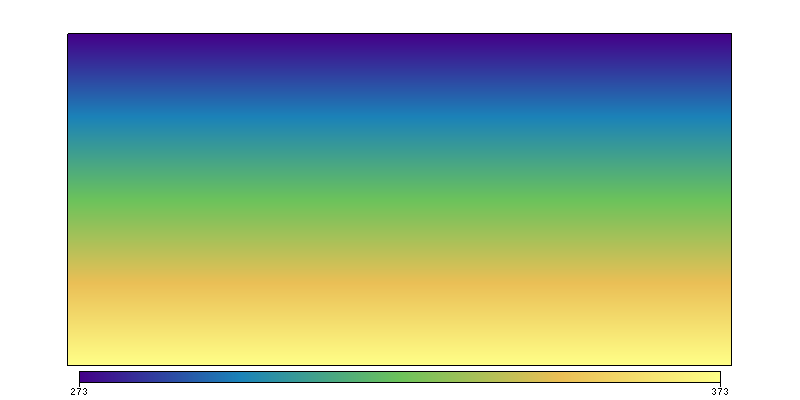

In [3]:
import underworld as uw
import glucifer

# 1.  Create a mesh.
mesh = uw.mesh.FeMesh_Cartesian(maxCoord=(2.,1.))

# 2.  Create the required field(s).
tempField = mesh.add_variable(1)

# 3.  Create required boundary condition object.
# 3.a First create the required IndexSet objects to specify the required boundary. 
#     Note shorthand addition operation. 
botSet = mesh.specialSets['Bottom_VertexSet']
topSet = mesh.specialSets[   'Top_VertexSet']
totSet = botSet + topSet
# 3.b Now we can create the Dirichlet condition object.
condition = uw.conditions.DirichletCondition(tempField,totSet)
# 3.c Let's set the g function now by directly modifying the temperatureField object.
#     Note that this operation can be done at any stage!
#     Note also the shorthand we use to set the required values. 
tempField.data[botSet] = 373.
tempField.data[topSet] = 273.

# 4.  Let's go ahead and set a simple diffusivity.
alpha = 1. 

# 5.  Create the required system.
heatSys = uw.systems.SteadyStateHeat(temperatureField=tempField, 
                                     fn_diffusivity=alpha, 
                                     conditions=condition)

# 6.  Create solver and solve.
solver = uw.systems.Solver(heatSys)
solver.solve()

# vis.
fig = glucifer.Figure(figsize=(800,400))
fig.append(glucifer.objects.Surface(mesh, tempField, colours="cubelaw2"))
fig.show()

Note in the above visualisation that we have satisfied our model requirements:

1. User specified Dirichlet condition is satisfied $(u=373 \text{ on } \Gamma_{\text{bottom}},\,\, u=273 \text{ on } \Gamma_{\text{top}})$.
1. Inspection suggests side boundaries have zero normal temperature gradient, but the example in the Neumann section below explicitly sets the zero flux Neumann condition and yields identical results. 

As mentioned, the user is free to flag any mesh nodes as knowns of the system, including nodes internal to the domain. They are also free to change their $g$ specification (ie, the values set on the `MeshVariable` boundaries) at any point, however if they wish to change the boundary specification ($\Gamma_g$), it is current necessary to create a new system object. Note also that while the user may freely set values on any node of the `MeshVariable` object, for instantaneous systems only values set on BC-flagged nodes will be retained after the `solve()` operation, with the solver then delegated to determine all other nodal values. We will demonstrate these behaviours in the following example:

,

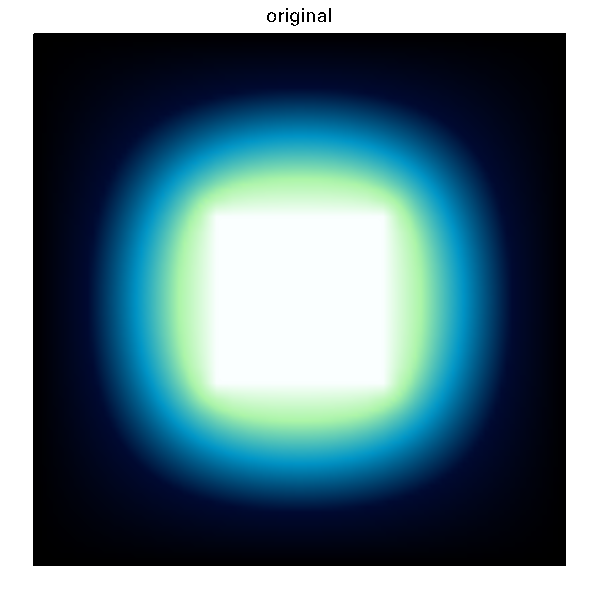
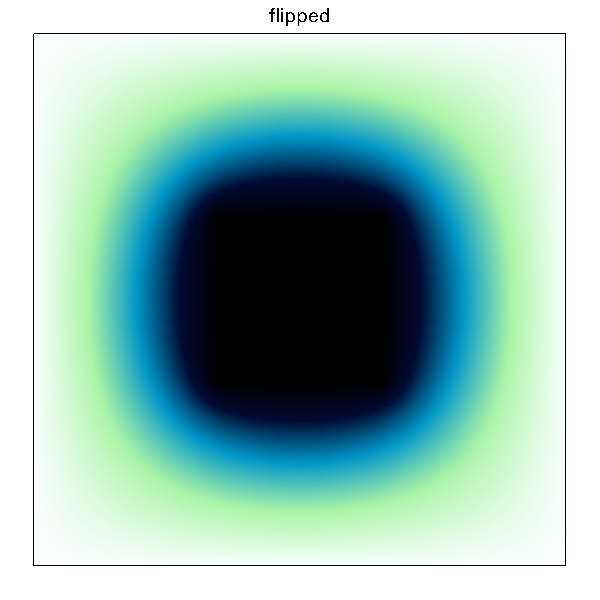

In [4]:
import underworld as uw
import glucifer
res=32
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(res,res),minCoord=(-0.5,-0.5), maxCoord=(0.5,0.5))
tempField = mesh.add_variable(1)

# create bc sets. first, allwalls.
allWallSet = mesh.specialSets['AllWalls_VertexSet']
# now grab central patch
centralSet = mesh.specialSets['Empty']
for index,coord in enumerate(mesh.data):
    if max(coord*coord)<0.03:
        centralSet.add(index)
condition = uw.conditions.DirichletCondition(tempField,centralSet+allWallSet)
tempField.data[allWallSet] = 0.
tempField.data[centralSet] = 1.

# for fun, let's also set a random non-bc node to a random value.
# the value will be replaced at solve time by the solver. 
tempField.data[res+2] = -999999. 

heatSys = uw.systems.SteadyStateHeat(temperatureField=tempField, 
                                     fn_diffusivity=1., 
                                     conditions=condition)
solver = uw.systems.Solver(heatSys)
solver.solve()

# grab a copy of solved data for later use, and then let's 
# flip the config and re-solve immediately
tempField_orig = tempField.copy(deepcopy=True)
tempField.data[allWallSet] = 1.
tempField.data[centralSet] = 0.
solver.solve()

# vis
fig1 = glucifer.Figure(figsize=(600,600), title="original")
fig1.append(glucifer.objects.Surface(mesh, tempField_orig, colours="ocean", colourBar=False, onMesh=False))
fig2 = glucifer.Figure(figsize=(600,600), title="flipped")
fig2.append(glucifer.objects.Surface(mesh, tempField     , colours="ocean", colourBar=False, onMesh=False))

glucifer.Figure.show_grid([fig1,fig2])

#### Vector Systems 
So far we have only considered scalar systems having only a single degree of freedom per mesh node. For the Stokes system however we solve for a velocity unknown having 2 or 3 DOFs per mesh node (for 2D and 3D simulations respectively). While the general process is unchanged, you will now be required to specify boundary conditions on a per-DOF basis. The way this is handled in Underworld is to have the user provide an `IndexSet` object for each DOF. So for the previous examples, only a single `IndexSet` was required for the single DOF of the temperature field, while for a velocity field we require 2 (or 3) `IndexSet` objects, one for the $V_x$ DOF, and another for the $V_y$ DOF (and a further for the $V_z$ DOF in 3D). 

##### No-Slip BCs
Let's consider the basic *no-slip* configuration first:

,

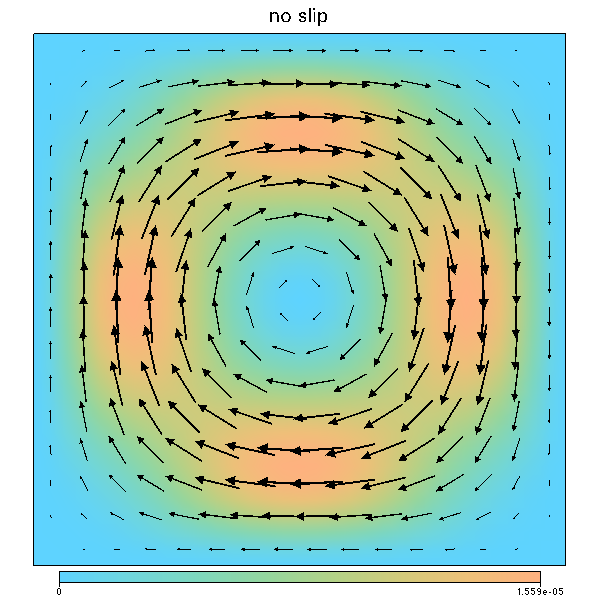
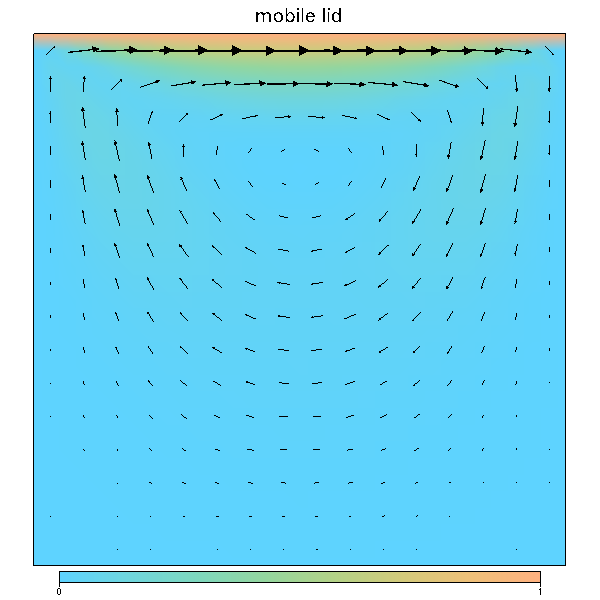

In [5]:
import underworld as uw
import glucifer

# 1.  Create a mesh.
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(32,32))

# 2.  Create the required field(s).
velField = mesh.add_variable(2)
preField = mesh.subMesh.add_variable(1)

# 3.  Create required boundary condition object.
allWalls = mesh.specialSets['AllWalls_VertexSet']
#     Note that we now pass in a tuple of IndexSet objects, representing
#     the nodes to flag for (V_x, V_y). For no-slip, we flag both DOFs for 
#     each node, so therefore the index sets must be identical.
#     Note also that we generally do not set any conditions on the pressure
#     unknowns. 
condition = uw.conditions.DirichletCondition(velField, (allWalls,allWalls) )
#     Init the velocity field to zero everywhere.  Therefore g=(0,0).
velField.data[:] = (0.,0.)

# 4.  Let's create a simple function for the viscosity & bodyforce.
viscosity = 1.
coord = uw.function.coord()
bodyforce = (0.,-coord[0])

# 5.  Create the required system.
stokesSys = uw.systems.Stokes(velocityField=velField, 
                              pressureField=preField, 
                              fn_viscosity=viscosity, 
                              fn_bodyforce=bodyforce, 
                              conditions=condition )

# 6.  Create solver and solve
solver = uw.systems.Solver(stokesSys)
solver.solve()

# Grab copy of solution.
noslipvel = velField.copy(deepcopy=True)

# As before, we can modify g at any point. 
# Create a mobile lid config:
topWall = mesh.specialSets['Top_VertexSet']
velField.data[topWall] = (1.,0.)
# also drop body force
stokesSys.fn_bodyforce = (0.,0.)
solver.solve()

# vis
fignoslip = glucifer.Figure(figsize=(600,600), title="no slip")
fignoslip.append(glucifer.objects.VectorArrows(mesh, noslipvel))
fignoslip.append(glucifer.objects.Surface(mesh, uw.function.math.dot(noslipvel,noslipvel), colours="isorainbow"))
figtraction = glucifer.Figure(figsize=(600,600), title="mobile lid")
figtraction.append(glucifer.objects.VectorArrows(mesh, velField))
figtraction.append(glucifer.objects.Surface(mesh, uw.function.math.dot(velField,velField), colours="isorainbow"))
glucifer.Figure.show_grid([fignoslip,figtraction])

##### Free-Slip BCs

The setup necessary to achieve a *free-slip* configuration is more complex. In this scenario, we wish to treat velocity components normal to the boundaries as knowns of the system, tethering this component to zero if we wish to prevent in/outflows. The tangential component should be left free to allow slip. Therefore, for a basic free-slip configuration on all walls of the standard cartesian geometry, we require:

1. Left/right wall nodes: $V_x = 0$, $V_y$ free.
1. Top/bottom wall nodes: $V_x$ free, $V_y = 0$.

This translates into flagging all the $V_x$ nodes on the left/right wall, and all the $V_y$ nodes on the top/bottom walls:

,

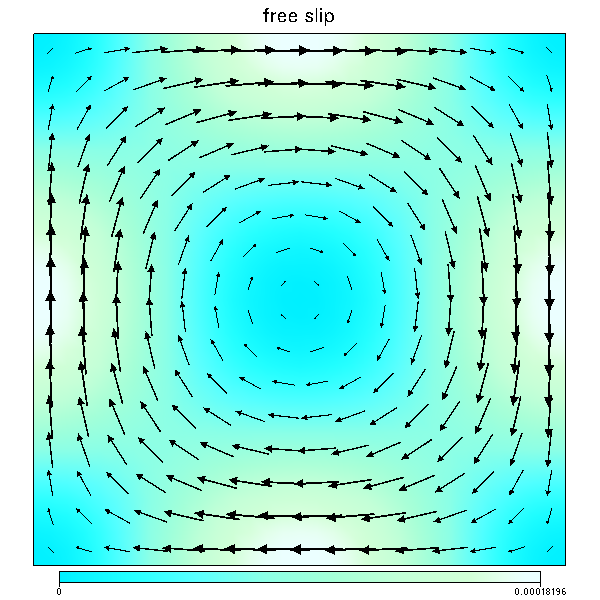
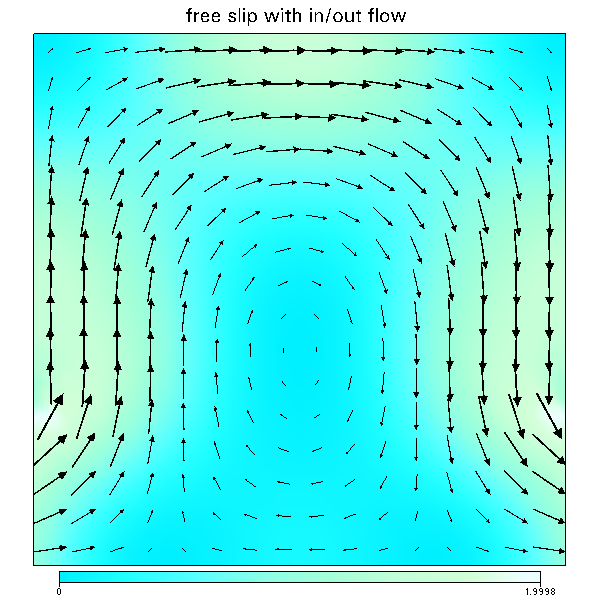

In [6]:
import underworld as uw
import glucifer

# 1.  Create a mesh.
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(32,32))

# 2.  Create the required field(s).
velField = mesh.add_variable(2)
preField = mesh.subMesh.add_variable(1)

# 3.  Create required boundary condition object.
leftrightWalls = mesh.specialSets['Left_VertexSet'] + mesh.specialSets['Right_VertexSet']
topbottWalls   = mesh.specialSets[ 'Top_VertexSet'] + mesh.specialSets['Bottom_VertexSet']
condition = uw.conditions.DirichletCondition(velField, (leftrightWalls,topbottWalls) )
#     Init the velocity field to zero everywhere.
velField.data[:] = (0.,0.)

# 4.  Let's create a simple function for the viscosity & bodyforce.
viscosity = 1.
coord = uw.function.coord()
bodyforce = (0.,-coord[0])

# 5.  Create the required system.
stokesSys = uw.systems.Stokes(velocityField=velField, 
                              pressureField=preField, 
                              fn_viscosity=viscosity, 
                              fn_bodyforce=bodyforce, 
                              conditions=condition )

# 6.  Create solver and solve
solver = uw.systems.Solver(stokesSys)
solver.solve()

# Grab copy of solution.
noslipvel = velField.copy(deepcopy=True)

# As before, we can modify g at any point. 
# Create inflow/outflow condition
for index in leftrightWalls:
    if mesh.data[index][1] < 0.3:
        velField.data[index] = (1.,0.)
# ramp up body force
stokesSys.fn_bodyforce = 100.*stokesSys.fn_bodyforce
solver.solve()

# vis
figfreeslip = glucifer.Figure(figsize=(600,600), title="free slip")
figfreeslip.append(glucifer.objects.VectorArrows(mesh, noslipvel))
figfreeslip.append(glucifer.objects.Surface(mesh, uw.function.math.dot(noslipvel,noslipvel), colours="gebco"))
figinflow = glucifer.Figure(figsize=(600,600), title="free slip with in/out flow")
figinflow.append(glucifer.objects.VectorArrows(mesh, velField))
figinflow.append(glucifer.objects.Surface(mesh, uw.function.math.dot(velField,velField), colours="gebco"))
glucifer.Figure.show_grid([figfreeslip,figinflow])

##### Inflow/Outflow

Note in the second example above that while you are free to create any inflow/outflow condition, unless you have otherwise specified, the system will be configured for incompessibility, and therefore any inflow must exactly balance outflow. For complex geometries, ensuring this balance is not always possible given the discrete nature of the models, and you might instead consider allowing some part of your domain to be compressible via the `fn_one_on_lambda` `Stokes` constructor parameter (refer to associated API reference for concise details).  

If you encounter solver difficulties while using inflow/outflow, it is often the case that you are violating volume conservation, and are therefore trying to find a solution that cannot exist. 

### The Neumann Condition

The general process for specifying a Neumann condition is almost identical to that for the Dirichlet condition. As before, you will specify the required boundary using `IndexSet` objects. However, as you are no longer fixing a value for the unknown itself (temperature, velocity, etc), but instead a derived quantity (heat flux, stress) you are now required to provide a `Function` object to specify the necessary $h$ function. Remember that `MeshVariable` objects are also `Function` objects, so you are free to create another `MeshVariable` to define $h$ if that makes most sense. Refer to the Function section of this guide for further details. 


,

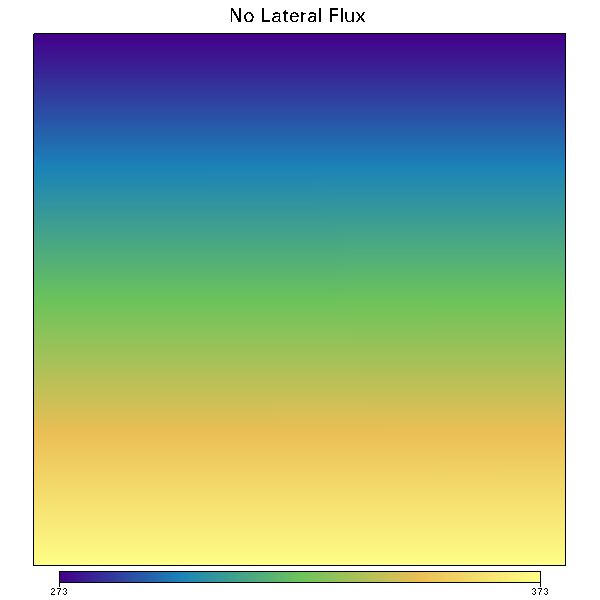
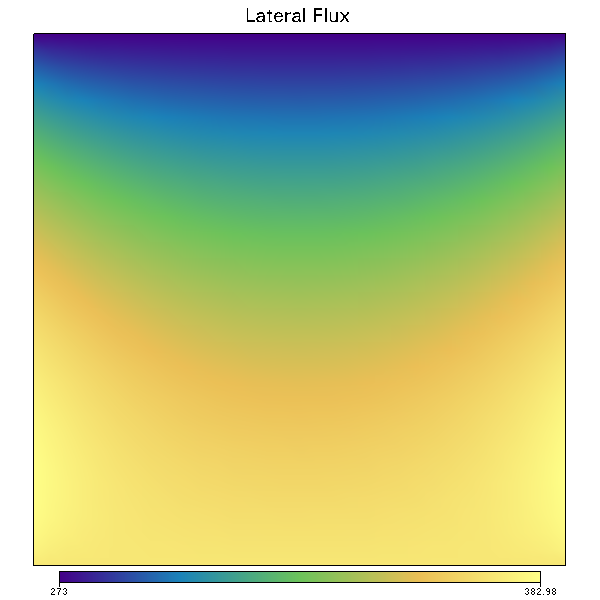

In [7]:
import underworld as uw
import glucifer

# 1.  Create a mesh.
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(32,32))

# 2.  Create the required field(s).
tempField = mesh.add_variable(1)

# 3.a  Create the Dirichlet Condition
botSet = mesh.specialSets['Bottom_VertexSet']
topSet = mesh.specialSets[   'Top_VertexSet']
totSet = botSet + topSet
cond_dirichlet = uw.conditions.DirichletCondition(tempField,totSet)
tempField.data[botSet] = 373.
tempField.data[topSet] = 273.
# 3.b  Create the Neumann condition
sidewalls = mesh.specialSets['Left_VertexSet'] + mesh.specialSets['Right_VertexSet']
#      Create this constant value function explicitly so we can
#      modify it later. 
flux = uw.function.Function.convert(0.)
cond_neumann = uw.conditions.NeumannCondition(tempField,sidewalls,flux)

# 4.  Diffusivity
alpha = 1. 

# 5.  Create the required system.
heatSys = uw.systems.SteadyStateHeat(temperatureField=tempField, 
                                     fn_diffusivity=alpha, 
                                     conditions=[cond_dirichlet,cond_neumann])

# 6.  Create solver and solve.
solver = uw.systems.Solver(heatSys)
solver.solve()

# grab copy 
nofluxTemp = tempField.copy(deepcopy=True)

# now set flux and re-solve
flux.value = -100.
solver.solve()

# vis.
fig_noflux = glucifer.Figure(figsize=(600,600), title="No Lateral Flux")
fig_noflux.append(glucifer.objects.Surface(mesh, nofluxTemp, colours="cubelaw2"))
fig_flux = glucifer.Figure(figsize=(600,600), title="Lateral Flux")
fig_flux.append(glucifer.objects.Surface(mesh, tempField, colours="cubelaw2"))
glucifer.Figure.show_grid([fig_noflux,fig_flux])


### Initial Conditions

For instantaneous systems (`SteadyStateHeat`, `SteadyStateDarcyFlow`, `Stokes`) you will not generally be required to set initial conditions, although care must be taken for non-linear systems.

For the `AdvectionDiffusion` system you will be required to configure your initial variable field as necessary. See the Mesh section of the user guide for examples on initialising `MeshVariable` objects. Naturally if your model utilises particles swarms, they will also need to be configured (see the Swarm section of the user guide). 

## Defining Physical Quantities

You will create an Underworld `Function` object to define your physical quantities. Refer to the Function section of the user guide for details. 

## Non-Linearity

Underworld currently provides a basic Picard based iterative scheme for solving non-linear problems. Note, depending on the form of your non-linearity, a reasonable initial field configuration may be required to avoid solver convergence difficulty or division by zero type issues. 

If your model has a non-linearity, the solver will flag you to this at solve time, and you must explicitly set the `solve()` parameter `nonLinearIterate` to `True` (Underworld will iterate for a solution) or `False` (Underworld will not iterate, but will perform a single solve). The `False` option might be used if you would like to explicitly handle the non-linearity, or perform some analysis or modifications after each iteration. An alternative option to enable per-iteration interaction is offered by the creating a callback function (passed in via the `callback_post_solve` paramater to the `solve()` method). 

In [8]:
import underworld as uw
import glucifer

# 1.  Create a mesh.
mesh = uw.mesh.FeMesh_Cartesian(elementRes=(32,32))

# 2.  Create the required field(s).
tempField = mesh.add_variable(1)

# 3.a  Create the Dirichlet Condition
botSet = mesh.specialSets['Bottom_VertexSet']
topSet = mesh.specialSets[   'Top_VertexSet']
totSet = botSet + topSet
cond_dirichlet = uw.conditions.DirichletCondition(tempField,totSet)
tempField.data[botSet] = 1.
tempField.data[topSet] = 0.

# 4.  Diffusivity
alpha = uw.function.math.exp(tempField)

# 5.  Create the required system.
heatSys = uw.systems.SteadyStateHeat(temperatureField=tempField, 
                                     fn_diffusivity=alpha, 
                                     conditions=[cond_dirichlet])

# 6.  Create solver and solve.
solver = uw.systems.Solver(heatSys)
# THIS WILL NOT WORK!
# solver.solve()
# THIS WILL
solver.solve(nonLinearIterate=True)

# Use a callback
rms_temp = uw.utils.Integral(tempField*tempField,mesh)
import numpy as np
def mycallback():
    print("Average temp is {}".format(np.sqrt(rms_temp.evaluate())))
# reset temp field first for demo
tempField.data[:] = 0.
tempField.data[botSet] = 1.
solver.solve(nonLinearIterate=True, callback_post_solve=mycallback)

Average temp is [ 0.58463673]
Average temp is [ 0.64936446]
Average temp is [ 0.6476043]
Average temp is [ 0.6476043]
